### Import statements 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skmetrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate
from fairlearn.metrics import false_positive_rate
from fairlearn.metrics import false_negative_rate
from fairlearn.metrics import mean_prediction
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import demographic_parity_ratio
from fairlearn.metrics import count
from fairlearn.postprocessing import ThresholdOptimizer
warnings.filterwarnings('ignore')

### Reading in data and exploratory data analysis

In [27]:
# First, we'll import the total data set

all_companies = pd.read_csv('/Users/guusjejuijn/Desktop/Scriptie/Programmeren/Scriptie/recruitmentdataset-2022-1.3.csv', 
                               delimiter = ',')

all_companies.head(5)

,Id,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,x8011e,female,24,German,Swimming,70,False,False,False,False,1,True,phd,A,True
1,x6077a,male,26,German,Golf,67,False,True,False,False,2,True,bachelor,A,False
2,x6006e,female,23,Dutch,Running,67,False,True,True,False,0,True,master,A,False
3,x2173b,male,24,Dutch,Cricket,70,False,True,False,False,1,True,master,A,True
4,x6241a,female,26,German,Golf,59,False,False,False,False,1,False,master,A,True


In [29]:
# We'll now make 4 subsets of the data, each consisting of the datapoints from one specific company 

company_a = all_companies[0:1000]
company_b = all_companies[1000:2000]
company_c = all_companies[2000:3000]
company_d = all_companies[3000:4000]

<AxesSubplot:xlabel='nationality', ylabel='count'>

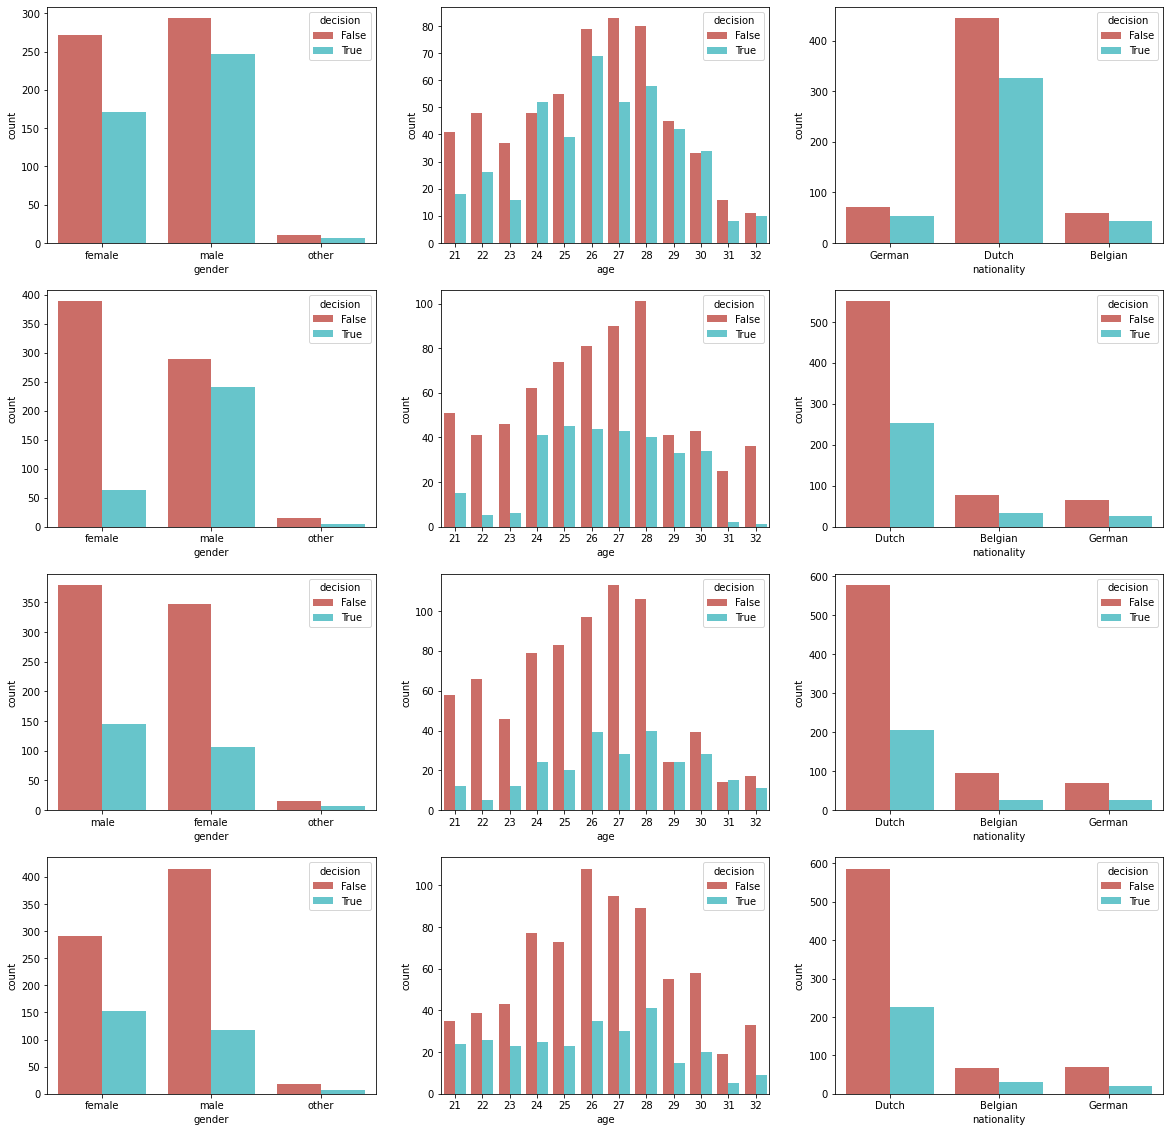

In [30]:
# To check which subset of the data includes the largest bias, 
# For each subset, we create count plots of the target variable (decision) and the sensitive attributes (nationality, gender, age) 

fig, axs = plt.subplots(4,3,figsize=(20, 20))

sn.countplot(company_a['gender'], hue=company_a.decision, palette = "hls", ax=axs[0,0])
sn.countplot(company_a['age'], hue=company_a.decision, palette = "hls", ax=axs[0,1])
sn.countplot(company_a['nationality'], hue=company_a.decision, palette = "hls", ax=axs[0,2])

sn.countplot(company_b['gender'], hue=company_b.decision, palette = "hls", ax=axs[1,0])
sn.countplot(company_b['age'], hue=company_b.decision, palette = "hls", ax=axs[1,1])
sn.countplot(company_b['nationality'], hue=company_b.decision, palette = "hls", ax=axs[1,2])

sn.countplot(company_c['gender'], hue=company_c.decision, palette = "hls", ax=axs[2,0])
sn.countplot(company_c['age'], hue=company_c.decision, palette = "hls", ax=axs[2,1])
sn.countplot(company_c['nationality'], hue=company_c.decision, palette = "hls", ax=axs[2,2])

sn.countplot(company_d['gender'], hue=company_d.decision, palette = "hls", ax=axs[3,0])
sn.countplot(company_d['age'], hue=company_d.decision, palette = "hls", ax=axs[3,1])
sn.countplot(company_d['nationality'], hue=company_d.decision, palette = "hls", ax=axs[3,2])

#### Based on the count plots above, we conclude that the data from company B (second row) includes a large gender bias: the percentage of females that get hired is clearly substantially lower than the percentage of males that get hired. As in the other data sets, no such large differences in receiving the favorable outcome (getting hired) between different groups are seen directly, we choose to continue our analysis with the data from company B. 

In [31]:
recruitmentdata = company_b
recruitmentdata.drop('Id', axis=1, inplace=True) # Drop ID column as it is not important for our analysis 
recruitmentdata.drop('sport', axis=1, inplace=True) # We also choose to drop the sport column, to decrease the number of features
recruitmentdata.head(5)

,gender,age,nationality,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
1000,female,21,Dutch,58,False,False,False,False,0,True,bachelor,B,False
1001,female,27,Dutch,67,False,False,True,False,0,True,master,B,False
1002,female,25,Dutch,56,True,False,False,False,2,False,bachelor,B,True
1003,female,28,Dutch,64,False,False,True,False,0,True,master,B,False
1004,male,30,Dutch,63,True,False,False,True,3,False,master,B,True


In [32]:
recruitmentdata.info() # Check for missing values and data types 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 1000 to 1999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 1000 non-null   object
 1   age                    1000 non-null   int64 
 2   nationality            1000 non-null   object
 3   ind-university_grade   1000 non-null   int64 
 4   ind-debateclub         1000 non-null   bool  
 5   ind-programming_exp    1000 non-null   bool  
 6   ind-international_exp  1000 non-null   bool  
 7   ind-entrepeneur_exp    1000 non-null   bool  
 8   ind-languages          1000 non-null   int64 
 9   ind-exact_study        1000 non-null   bool  
 10  ind-degree             1000 non-null   object
 11  company                1000 non-null   object
 12  decision               1000 non-null   bool  
dtypes: bool(6), int64(3), object(4)
memory usage: 60.7+ KB


In [33]:
# Ttransform boolean column types, and ind-languages column, into objects 

recruitmentdata['ind-debateclub'] = recruitmentdata['ind-debateclub'].astype('O')
recruitmentdata['ind-programming_exp'] = recruitmentdata['ind-programming_exp'].astype('O')
recruitmentdata['ind-international_exp'] = recruitmentdata['ind-international_exp'].astype('O')
recruitmentdata['ind-entrepeneur_exp'] = recruitmentdata['ind-entrepeneur_exp'].astype('O')
recruitmentdata['ind-exact_study'] = recruitmentdata['ind-exact_study'].astype('O')
recruitmentdata['decision'] = recruitmentdata['decision'].astype('O')
recruitmentdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 1000 to 1999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 1000 non-null   object
 1   age                    1000 non-null   int64 
 2   nationality            1000 non-null   object
 3   ind-university_grade   1000 non-null   int64 
 4   ind-debateclub         1000 non-null   object
 5   ind-programming_exp    1000 non-null   object
 6   ind-international_exp  1000 non-null   object
 7   ind-entrepeneur_exp    1000 non-null   object
 8   ind-languages          1000 non-null   int64 
 9   ind-exact_study        1000 non-null   object
 10  ind-degree             1000 non-null   object
 11  company                1000 non-null   object
 12  decision               1000 non-null   object
dtypes: int64(3), object(10)
memory usage: 101.7+ KB


In [34]:
recruitmentdata.describe() # Describe the numerical data

,age,ind-university_grade,ind-languages
count,1000.00000,1000.000000,1000.000000
mean,26.30700,62.348000,1.375000
std,2.81081,6.015237,0.856217
min,21.00000,47.000000,0.000000
25%,24.00000,58.000000,1.000000
50%,26.00000,62.000000,1.000000
75%,28.00000,67.000000,2.000000
max,32.00000,78.000000,3.000000


In [35]:
recruitmentdata.describe(include='O') # Describe the categorical data

,gender,nationality,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-exact_study,ind-degree,company,decision
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,3,3,2,2,2,2,2,3,1,2
top,male,Dutch,False,False,False,False,False,bachelor,B,False
freq,530,802,754,685,767,755,539,495,1000,691


The percentage of negative recruitment decisions : 0.69
The percentage of positive recruitment decisions: 0.31



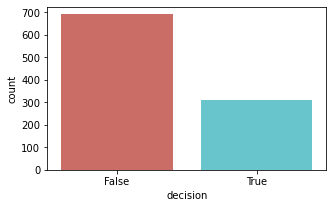

In [36]:
# Plot distribution of target variable (0 = false (not hired), 1 = true (hired))

plt.figure(figsize=(5,3))
sn.countplot(recruitmentdata.decision, palette="hls");

print('The percentage of negative recruitment decisions : %.2f' % (recruitmentdata['decision'].value_counts()[0] / len(recruitmentdata)))
print('The percentage of positive recruitment decisions: %.2f' % (recruitmentdata['decision'].value_counts()[1] / len(recruitmentdata)))
print()

<AxesSubplot:xlabel='nationality', ylabel='count'>

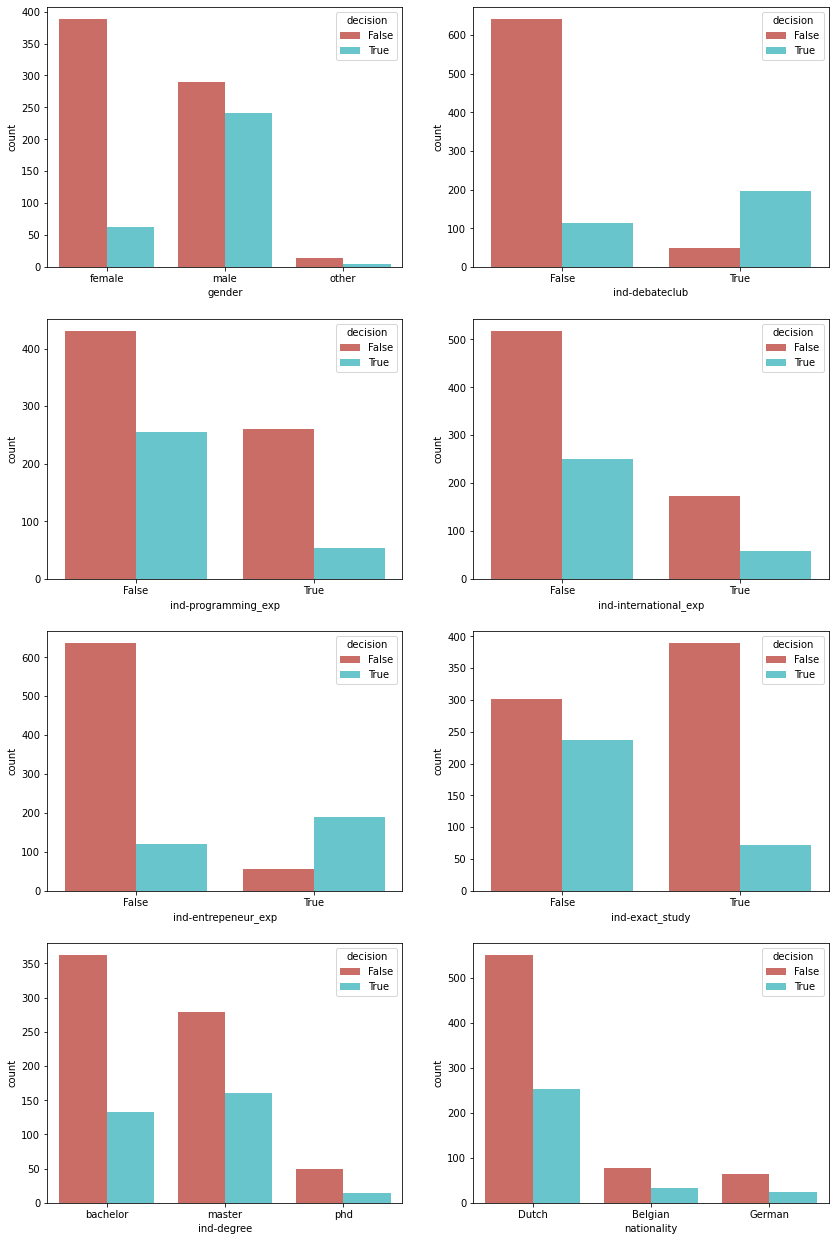

In [37]:
# Create count plots of all categorical attributes (decision 0 = not hired, decision 1 = hired)

fig, axs = plt.subplots(4,2,figsize=(14, 22))
sn.countplot(recruitmentdata.gender, hue=recruitmentdata.decision, palette = "hls", ax=axs[0,0])
sn.countplot(recruitmentdata['ind-debateclub'], hue=recruitmentdata.decision, palette = "hls", ax=axs[0,1])
sn.countplot(recruitmentdata['ind-programming_exp'], hue=recruitmentdata.decision, palette = "hls", ax=axs[1,0])
sn.countplot(recruitmentdata['ind-international_exp'], hue=recruitmentdata.decision, palette = "hls", ax=axs[1,1])
sn.countplot(recruitmentdata['ind-entrepeneur_exp'], hue=recruitmentdata.decision, palette = "hls", ax=axs[2,0])
sn.countplot(recruitmentdata['ind-exact_study'], hue=recruitmentdata.decision, palette = "hls", ax=axs[2,1])
sn.countplot(recruitmentdata['ind-degree'], hue=recruitmentdata.decision, palette = "hls", ax=axs[3,0])
sn.countplot(recruitmentdata['nationality'], hue=recruitmentdata.decision, palette = "hls", ax=axs[3,1])

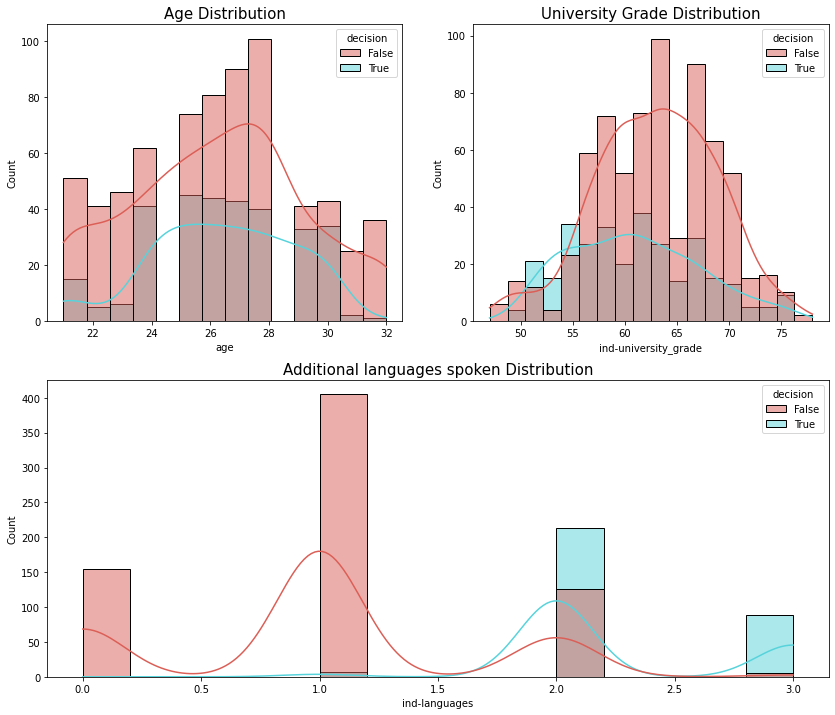

In [38]:
# Create histograms of all numerical attributes (decision 0 = not hired, 1 = hired)

plt.figure(figsize=(14, 12))

plt.subplot(221)
ax1 = sn.histplot(data=recruitmentdata, x='age', hue='decision', palette='hls', kde=True)
ax1.set_title("Age Distribution", fontsize=15)

plt.subplot(222)
ax1 = sn.histplot(data=recruitmentdata, x='ind-university_grade', hue='decision', palette='hls', kde=True)
ax1.set_title("University Grade Distribution", fontsize=15)

plt.subplot(212)
ax1 = sn.histplot(data=recruitmentdata, x='ind-languages', hue='decision', palette='hls', kde=True)
ax1.set_title("Additional languages spoken Distribution", fontsize=15)

plt.show()

In [39]:
recruitmentdata['gender'].value_counts() #Since the data largely contains male and female subjects, 
                                        # For conveninience, we only choose to use these two sexes in this analysis

male      530
female    451
other      19
Name: gender, dtype: int64

In [40]:
# Look for disparate impact in the data set, using column info 

female = recruitmentdata.loc[recruitmentdata['gender'] == "female"] 
male = recruitmentdata.loc[recruitmentdata['gender'] == "male"] 

favorable_female = female.loc[female['decision'] == 1] 
unfavorable_female = female.loc[female['decision'] == 0] 
print("Number of females who get hired: ", len(favorable_female)) 
print("Number of females who do not get hired: ", len(unfavorable_female)) 
prop_female_favorable = len(favorable_female)/len(female)
print("Proportion of females receiving the favorable outcome: ", prop_female_favorable) 
print()

favorable_male = male.loc[male['decision'] == 1] 
unfavorable_male = male.loc[male['decision'] == 0]
print("Number of males who get hired: ", len(favorable_male)) 
print("Number of males who do not get hired: ", len(unfavorable_male)) 
prop_male_favorable = len(favorable_male)/len(male)
print("Proportion of males receiving the favorable outcome: ", prop_male_favorable) 
print()

disparate_impact = prop_female_favorable / prop_male_favorable
print("The disparate impact ratio between the unprivileged (females) group and privileged group (males) is : %.2f " % disparate_impact)

Number of females who get hired:  63
Number of females who do not get hired:  388
Proportion of females receiving the favorable outcome:  0.13968957871396895

Number of males who get hired:  241
Number of males who do not get hired:  289
Proportion of males receiving the favorable outcome:  0.4547169811320755

The disparate impact ratio between the unprivileged (females) group and privileged group (males) is : 0.31 


####  We can conclude that this data set is indeed highly biased against females: the disparate impact ratio is 0.3

### Splitting data into train and test set 

In [41]:
input_attributes = recruitmentdata.iloc[0:,0:12] # Split the data into input attributes and target attribute 
target_attribute = recruitmentdata['decision']

cat_columns = ["gender", "nationality", "ind-debateclub", "ind-programming_exp", 
               "ind-international_exp", "ind-entrepeneur_exp",
                "ind-exact_study", "ind-degree"]
num_columns = ["age", "ind-university_grade", "ind-languages"]

X = input_attributes[cat_columns + num_columns]

# Split data into train and test set. Change target attribute into int, since now it is an object type which sklearn cannot recognize
x_train, x_test, y_train, y_test = train_test_split(X, target_attribute.astype('int'), test_size=0.25, random_state=42)

x_train.reset_index(drop=True, inplace=True) # Reset indices
x_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Preprocessing: one-hot encoding the categorical attributes, scale the numerical features and define sensitive features

In [42]:
encoder = OneHotEncoder()
scaler=MinMaxScaler()

preprocessing = ColumnTransformer(
    [
        ("categorical", encoder, cat_columns),
        ("numerical", scaler, num_columns)
    ],
    verbose_feature_names_out=False,
)

In [43]:
gender = x_test['gender'] # Define sensitive features 
gender.value_counts()

male      124
female    122
other       4
Name: gender, dtype: int64

### Logistic Regression

In [44]:
unmitigated_lr = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", LogisticRegression(C=10,random_state=42)),
    ]
)
unmitigated_lr.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['gender', 'nationality',
                                                   'ind-debateclub',
                                                   'ind-programming_exp',
                                                   'ind-international_exp',
                                                   'ind-entrepeneur_exp',
                                                   'ind-exact_study',
                                                   'ind-degree']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['age',
                                                   'ind-university_grade',
                                                   'ind-languages'])],
                                   verbose_feature_names_out=False)),
                ('classifier', LogisticRegression(C=10, random_state=42))])

In [45]:
print(f"LR train accuracy: {unmitigated_lr.score(x_train, y_train):.3f}")
print(f"LR test accuracy: {unmitigated_lr.score(x_test, y_test):.3f}")

LR train accuracy: 0.884
LR test accuracy: 0.876


In [46]:
predictions_lr = unmitigated_lr.predict(x_test)
predictions_lr

print(skmetrics.classification_report(y_test, predictions_lr)) 

conf_matrix = skmetrics.confusion_matrix(y_test, predictions_lr)
print(conf_matrix)  

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       177
           1       0.78      0.79      0.79        73

    accuracy                           0.88       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.88      0.88      0.88       250

[[161  16]
 [ 15  58]]


In [47]:
# Show metrics per group

metrics = {"accuracy":accuracy_score, "selection rate": selection_rate, "mean prediction": mean_prediction,
           "false positive rate": false_positive_rate, "false negative rate": false_negative_rate, "count": count}
mf_lr = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=predictions_lr,
    sensitive_features=gender)

print("Metrics by group: ") 
mf_lr.by_group


Metrics by group: 


,accuracy,selection rate,mean prediction,false positive rate,false negative rate,count
gender,,,,,,
female,0.918033,0.122951,0.122951,0.046729,0.333333,122.0
male,0.846774,0.467742,0.467742,0.149254,0.157895,124.0
other,0.500000,0.250000,0.250000,0.333333,1.000000,4.0


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'mean prediction'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'false negative rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'count'}, xlabel='gender'>],
       [<AxesSubplot:xlabel='gender'>, <AxesSubplot:xlabel='gender'>,
        <AxesSubplot:xlabel='gender'>]], dtype=object)

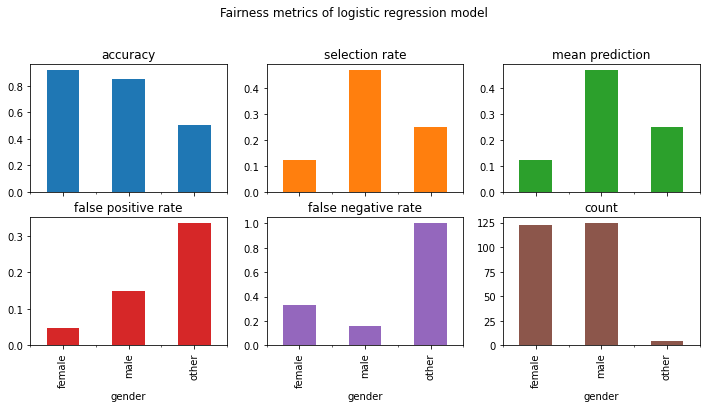

In [48]:
# Plot metrics by group

mf_lr.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Fairness metrics of logistic regression model",
)

###  Investigate feature importance

In [51]:
featureimportance = pd.DataFrame(data={
                                'Feature': preprocessing.get_feature_names_out(),
                                 'Importance': unmitigated_lr['classifier'].coef_[0]})
featureimportance = featureimportance.sort_values(by='Importance', ascending=False) # Sorted dataframe of all features and their coefficients

pd.qcut(featureimportance['Importance'], q=11)  #Divide all features up into 11 buckets (+++++ to -----)
binned = pd.qcut(featureimportance['Importance'], q=11)
binned_df = pd.DataFrame(binned)

binned_df['Feature'] = featureimportance['Feature']
print(binned_df)

           Importance                      Feature
21     (0.647, 9.672]                ind-languages
17     (0.647, 9.672]            ind-degree_master
20     (0.407, 0.647]         ind-university_grade
7      (0.407, 0.647]          ind-debateclub_True
14     (0.261, 0.407]        ind-exact_study_False
1      (0.261, 0.407]                  gender_male
5      (0.215, 0.261]           nationality_German
13     (0.215, 0.261]     ind-entrepeneur_exp_True
8      (0.126, 0.215]    ind-programming_exp_False
10     (0.126, 0.215]  ind-international_exp_False
3    (-0.0963, 0.126]          nationality_Belgian
2    (-0.0963, 0.126]                 gender_other
11  (-0.215, -0.0963]   ind-international_exp_True
9   (-0.215, -0.0963]     ind-programming_exp_True
12   (-0.306, -0.215]    ind-entrepeneur_exp_False
0    (-0.306, -0.215]                gender_female
4    (-0.359, -0.306]            nationality_Dutch
18   (-0.359, -0.306]               ind-degree_phd
15   (-0.466, -0.359]         i

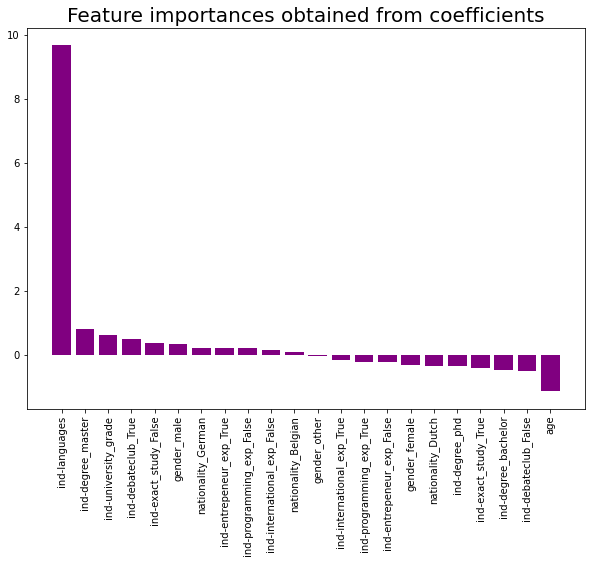

In [52]:
# Plot of all features and their belonging coefficients 

plt.figure(figsize=(10,7))
plt.bar(x=featureimportance['Feature'], height=featureimportance['Importance'], color='purple')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()


### Bias mitigation 

In [53]:
#Postprocessing for demographic parity 

postprocess_dp = ThresholdOptimizer(estimator=unmitigated_lr, constraints="demographic_parity", 
                                     objective="accuracy_score",prefit=True,predict_method='predict_proba')

postprocess_dp.fit(x_train, y_train, sensitive_features = x_train['gender'])

ThresholdOptimizer(estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               OneHotEncoder(),
                                                                               ['gender',
                                                                                'nationality',
                                                                                'ind-debateclub',
                                                                                'ind-programming_exp',
                                                                                'ind-international_exp',
                                                                                'ind-entrepeneur_exp',
                                                                                'ind-exact_study',
                                                                                'ind-degree']),
                                                                              ('numerical',
                                                                               MinMaxScaler(),
                                                                               ['age',
                                                                                'ind-university_grade',
                                                                                'ind-languages'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(C=10,
                                                                 random_state=42))]),
                   predict_method='predict_proba', prefit=True)

In [54]:
predictions_lr_postpr = postprocess_dp.predict(x_test, sensitive_features=gender)

print(skmetrics.classification_report(y_test, predictions_lr_postpr)) 
print()
conf_matrix = skmetrics.confusion_matrix(y_test, predictions_lr_postpr)
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.84      0.92      0.87       177
           1       0.73      0.56      0.64        73

    accuracy                           0.81       250
   macro avg       0.78      0.74      0.75       250
weighted avg       0.81      0.81      0.80       250


[[162  15]
 [ 32  41]]


In [55]:
# Show metrics by group after mitigation

mf_lr_postpr = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=predictions_lr_postpr,
    sensitive_features=gender)

print("Metrics by group: ") 
mf_lr_postpr.by_group

Metrics by group: 


,accuracy,selection rate,mean prediction,false positive rate,false negative rate,count
gender,,,,,,
female,0.893443,0.196721,0.196721,0.102804,0.133333,122.0
male,0.741935,0.250000,0.250000,0.044776,0.508772,124.0
other,0.500000,0.250000,0.250000,0.333333,1.000000,4.0


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'mean prediction'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'false negative rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'count'}, xlabel='gender'>],
       [<AxesSubplot:xlabel='gender'>, <AxesSubplot:xlabel='gender'>,
        <AxesSubplot:xlabel='gender'>]], dtype=object)

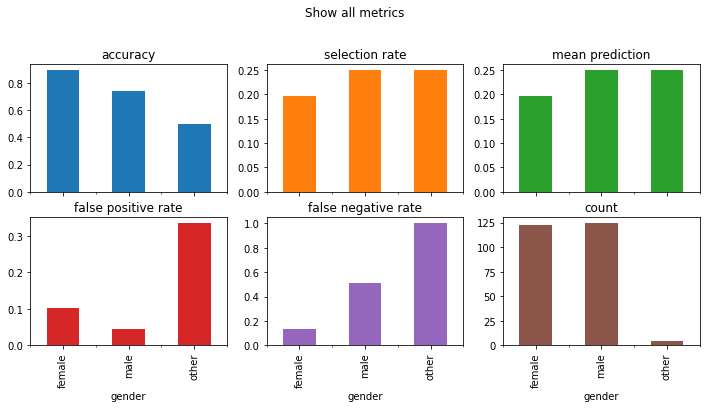

In [56]:
# Plot metrics by group after mitigation 

mf_lr_postpr.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [57]:
# Postprocessing for equality of opportunity 

postprocess_eqo = ThresholdOptimizer(estimator=unmitigated_lr, constraints="false_negative_rate_parity", 
                                     objective="accuracy_score",prefit=True,predict_method='predict_proba')

postprocess_eqo.fit(x_train, y_train, sensitive_features = x_train['gender'])

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               OneHotEncoder(),
                                                                               ['gender',
                                                                                'nationality',
                                                                                'ind-debateclub',
                                                                                'ind-programming_exp',
                                                                                'ind-international_exp',
                                                                                'ind-entrepeneur_exp',
                                                                                'ind-exact_study',
                                                                                'ind-degree']),
                                                                              ('numerical',
                                                                               MinMaxScaler(),
                                                                               ['age',
                                                                                'ind-university_grade',
                                                                                'ind-languages'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(C=10,
                                                                 random_state=42))]),
                   predict_method='predict_proba', prefit=True)

In [58]:
predictions_lr_postpr_eqo = postprocess_eqo.predict(x_test, sensitive_features=gender)

print(skmetrics.classification_report(y_test, predictions_lr_postpr_eqo)) 
print()
conf_matrix = skmetrics.confusion_matrix(y_test, predictions_lr_postpr_eqo)
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       177
           1       0.77      0.84      0.80        73

    accuracy                           0.88       250
   macro avg       0.85      0.87      0.86       250
weighted avg       0.88      0.88      0.88       250


[[159  18]
 [ 12  61]]


In [59]:
# Show metrics by group after mitigation

mf_lr_postpr = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=predictions_lr_postpr_eqo,
    sensitive_features=gender)

print("Metrics by group: ") 
mf_lr_postpr.by_group

Metrics by group: 


,accuracy,selection rate,mean prediction,false positive rate,false negative rate,count
gender,,,,,,
female,0.926230,0.163934,0.163934,0.065421,0.133333,122.0
male,0.846774,0.467742,0.467742,0.149254,0.157895,124.0
other,0.500000,0.250000,0.250000,0.333333,1.000000,4.0


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'mean prediction'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'false negative rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'count'}, xlabel='gender'>],
       [<AxesSubplot:xlabel='gender'>, <AxesSubplot:xlabel='gender'>,
        <AxesSubplot:xlabel='gender'>]], dtype=object)

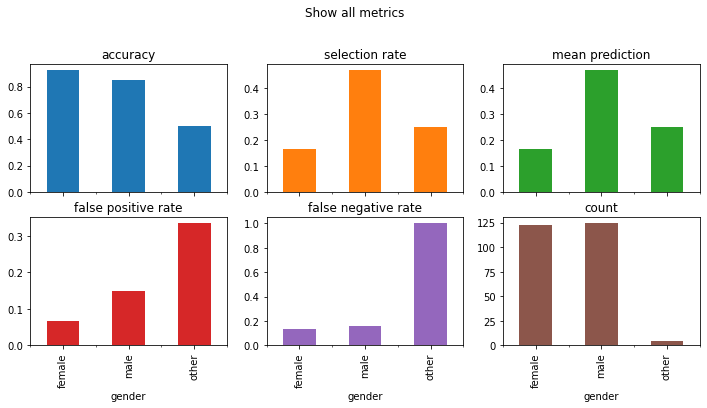

In [60]:
# Plot metrics by group after mitigation 

mf_lr_postpr.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)